In [1]:
"""3D analysis of the Galactic Center DC1 dataset.
Here all the models are defined and 
The cubes/maps (counts, exposure, background) 
and IRFs (EDISP, PSF) were already produced by the make_maps_IRFs.py code
"""
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import os,time
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.table import Table, vstack
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion
from gammapy.maps import Map, WcsGeom, MapAxis, WcsNDMap
from gammapy.cube import MapMaker, MapEvaluator, MapFit, PSFKernel
from gammapy.cube.models import SkyModel, SkyDiffuseCube
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw, LogParabola
from gammapy.image.models import SkyDisk, SkyShell, SkyDiffuseMap, SkyGaussian, SkyPointSource, SkyDiffuseMap

log = logging.getLogger()

## Setup

In [2]:
target_glon = 359.944 * u.deg  #actual SgrA* position
target_glat = -0.046 * u.deg
# target_radius = 0.5 * u.deg
target_skycoord = SkyCoord(target_glon, target_glat, frame="galactic")

on_radius = 1 * u.deg
on_region = CircleSkyRegion(target_skycoord, on_radius)

offset_max = 10 * u.deg

# energy_min = 0.1 * u.TeV
# energy_max = 160 * u.TeV
# energy_nbins = 35
# energy_bins = np.logspace(
#     start=np.log10(energy_min.value),
#     stop=np.log10(energy_max.value),
#     num=energy_nbins,
# )

energy_axis = MapAxis.from_bounds(
    0.1, 160, 35, unit="TeV", name="energy", interp="log"
)
map_geom = WcsGeom.create(
    skydir=target_skycoord,
    width=(8, 8),
    binsz=0.02,
    coordsys="GAL",
    axes=[energy_axis],
)

## Read maps and IRFs

In [3]:
#read maps
counts = Map.read("counts_cube.fits.gz")
background = Map.read("background_cube.fits.gz")
exposure=Map.read("exposure_cube.fits.gz")

#read IRFs
psf_kernel = PSFKernel.read("psf.fits.gz")
edisp = EnergyDispersion.read("edisp.fits.gz")

## Make IEM and Fermi Bubble cutout and reproject
We need to do this in order to use IEM or Fermi Bubble in our fitting model.

In [4]:
iem_filename = "iem_cube_cutout.fits.gz"
if os.path.isfile(iem_filename) == False:
    log.info(f"Producing cutout map for IEM and writing {iem_filename}")
    map_geom.to_image()
    m = Map.read("$CTADATA/models/cube_iem.fits.gz")
    m = m.reproject(map_geom.to_image())
    m.write(iem_filename, overwrite=True)
    
fermibb_filename = "fermi_bubbles_map_cutout.fits.gz"
if os.path.isfile(fermibb_filename) == False:
    log.info(f"Producing cutout map for Fermi Bubbles and writing {fermibb_filename}")
    map_geom.to_image()
    n = Map.read("$CTADATA/models/map_fermi_bubbles.fits.gz")
    n = n.reproject(map_geom.to_image())
    n.write(fermibb_filename, overwrite=True)

## Make model maps

In [5]:
#IEM:
model_iem = SkyDiffuseCube.read("iem_cube_cutout.fits.gz")

#Fermi Bubbles
model_fermibb = SkyModel(
    SkyDiffuseMap(map=Map.read(fermibb_filename), norm=1, normalize=True),
    LogParabola(alpha=1.6, beta=0.09,  amplitude='0.5e-11 cm-2 s-1 TeV-1', reference='1 TeV' )
) 

#GC source / J1745-290
model_gc = SkyModel(
    SkyPointSource("0.01d", "0.01d"),
    ExponentialCutoffPowerLaw(amplitude="1e-12 cm-2 s-1 TeV-1", index=1.0, reference="1 TeV", lambda_=1 / u.TeV)
)

# in order to set min and max, the fit cannot autoscale, or it needs to autoscale the min and max as well. 
#model_gc.parameters["lat_0"].scale = 1
#model_gc.parameters["lat_0"].min = -0.2  #*1e-2 
#model_gc.parameters["lat_0"].max = 0.2
#model_gc.parameters["lon_0"].scale = 1
#model_gc.parameters["lon_0"].min = -0.2 
#model_gc.parameters["lon_0"].max = 0.2



#G0.9+0.1
model_G09 = SkyModel(
    SkyPointSource("0.9d", "0.1d"),
    PowerLaw(amplitude="1e-12 cm-2 s-1 TeV-1", index=1.0, reference="1 TeV")
)

#model_G09.parameters["lat_0"].scale = 1
#model_G09.parameters["lat_0"].min = 0.7 
#model_G09.parameters["lat_0"].max = 1.1
#model_G09.parameters["lon_0"].scale = 1
#model_G09.parameters["lon_0"].min = -0.1 
#model_G09.parameters["lon_0"].max = 0.3


#HESS J1745-303
model_J1745_303 = SkyModel( 
    SkyGaussian("358.872d", "-0.578d", sigma="0.2 deg"),
    PowerLaw(amplitude="1e-12 cm-2 s-1 TeV-1", index=1.0, reference="1 TeV")
)

## Fit mask and map cutout
First we are cutting out only a part of the maps, so that the fitting procedure does not take too long.

In [7]:
cmaps = {
    "counts": counts.cutout(SkyCoord(0, 0, unit="deg", frame="galactic"), 4 * u.deg),
    "background": background.cutout(SkyCoord(0, 0, unit="deg", frame="galactic"), 4 * u.deg),
    "exposure": exposure.cutout(SkyCoord(0, 0, unit="deg", frame="galactic"), 4 * u.deg),
}
#cmaps["counts"].sum_over_axes().plot(stretch="sqrt");

Spatial masks:

(<matplotlib.figure.Figure at 0x7fc237e03978>,
 None)

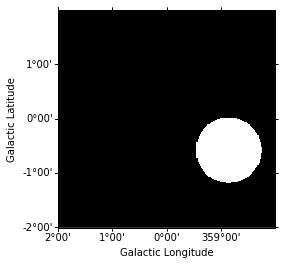

In [8]:
# GC mask
mask_gc = Map.from_geom(cmaps["counts"].geom)
region_gc = CircleSkyRegion(center=target_skycoord, radius=0.6 * u.deg)
mask_gc.data = mask_gc.geom.region_mask([region_gc])

# G0.9 mask
mask_G09 = Map.from_geom(cmaps["counts"].geom)
region_G09 = CircleSkyRegion(center=SkyCoord(0.87 * u.deg, 0.07 * u.deg, frame="galactic"), radius=0.15 * u.deg)
mask_G09.data = mask_G09.geom.region_mask([region_G09])

# HESS J1745-303 mask
mask_J1745_303 = Map.from_geom(cmaps["counts"].geom)
region_J1745_303 = CircleSkyRegion(center=SkyCoord(358.872 * u.deg, -0.578 * u.deg, frame="galactic"), radius=0.6 * u.deg)
mask_J1745_303.data = mask_J1745_303.geom.region_mask([region_J1745_303])

mask_J1745_303.get_image_by_idx((0,)).plot()

Spectral mask (above 0.3 TeV):

In [9]:
coords = mask_gc.geom.get_coord()
mask_gc.data &= coords["energy"] > 0.3
mask_G09.data &= coords["energy"] > 0.3
mask_J1745_303.data &= coords["energy"] > 0.3

## Fitting point sources: GC and G0.9+0.1

In [10]:
model_point = model_gc #+ model_G09
#model_point.parameters.apply_autoscale = False   # first try shows a lot of RuntimeWarnings and fit does not converge
fit = MapFit(
    model=model_point,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    mask=mask_gc,
    psf=psf_kernel,
    edisp=edisp,
)

In [11]:
%%time
result = fit.run(optimize_opts={"print_level": 1})
#result = fit.run()

#print(result.model)

FCN = -4564970.32517259 
 TOTAL NCALL = 294 
 NCALLS = 294 
 
 
 EDM = 2.75604002596717e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,par_000_lon_0,-5.51909,0.01121,,,,,No
1,par_001_lat_0,-4.63434,0.0112846,,,,,No
2,par_002_index,2.19024,0.00495173,,,,,No
3,par_003_amplitude,3.1242,0.0128328,,,,,No
4,par_004_reference,1,1,,,,,Yes
5,par_005_lambda_,0.081097,0.00179238,,,,,No


CPU times: user 2min 20s, sys: 699 ms, total: 2min 20s
Wall time: 2min 21s


In [12]:
#model_point = result.model + model_G09
#
#params = model_point.model1.parameters
#for x in params:
#    x.frozen = True
print(result.model)


SkyModel

spatial_model = SkyPointSource

Parameters: 

	 name   value      error   unit min max
	----- ---------- --------- ---- --- ---
	lon_0 -5.519e-02 1.121e-04  deg nan nan
	lat_0 -4.634e-02 1.128e-04  deg nan nan

Covariance: 

	 name   lon_0     lat_0  
	----- --------- ---------
	lon_0 1.257e-08 5.854e-11
	lat_0 5.854e-11 1.273e-08

spectral_model = ExponentialCutoffPowerLaw

Parameters: 

	   name     value     error         unit      min max
	--------- --------- --------- --------------- --- ---
	    index 2.190e+00 4.952e-03                 nan nan
	amplitude 3.124e-12 1.283e-14 1 / (cm2 s TeV) nan nan
	reference 1.000e+00 0.000e+00             TeV nan nan
	  lambda_ 8.110e-02 1.792e-03         1 / TeV nan nan

Covariance: 

	   name     index    amplitude  reference  lambda_  
	--------- ---------- ---------- --------- ----------
	    index  2.452e-05 -3.478e-17 0.000e+00 -7.161e-06
	amplitude -3.478e-17  1.647e-28 0.000e+00  1.672e-17
	reference  0.000e+00  0.000e+00 0.00

In [13]:
fit_2 = MapFit(
    model=model_G09,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    mask=mask_G09,
    psf=psf_kernel,
    edisp=edisp,
)

In [14]:
%%time
result_2 = fit_2.run(optimize_opts={"print_level": 1})

FCN = -671735.2442133665 
 TOTAL NCALL = 286 
 NCALLS = 286 
 
 
 EDM = 2.035711285357684e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,par_000_lon_0,0.863329,0.00017255,,,,,No
1,par_001_lat_0,0.902297,0.00171269,,,,,No
2,par_002_index,2.43493,0.00403946,,,,,No
3,par_003_amplitude,1.25745,0.00551921,,,,,No
4,par_004_reference,1,1,,,0,,Yes


CPU times: user 1min 50s, sys: 380 ms, total: 1min 50s
Wall time: 1min 51s


In [15]:
print(result_2.model)

SkyModel

spatial_model = SkyPointSource

Parameters: 

	 name   value     error   unit min max
	----- --------- --------- ---- --- ---
	lon_0 8.633e-01 1.725e-04  deg nan nan
	lat_0 9.023e-02 1.713e-04  deg nan nan

Covariance: 

	 name   lon_0      lat_0   
	----- ---------- ----------
	lon_0  2.977e-08 -1.629e-10
	lat_0 -1.629e-10  2.933e-08

spectral_model = PowerLaw

Parameters: 

	   name     value     error         unit         min    max
	--------- --------- --------- --------------- --------- ---
	    index 2.435e+00 4.039e-03                       nan nan
	amplitude 1.257e-12 5.519e-15 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00 0.000e+00             TeV 0.000e+00 nan

Covariance: 

	   name     index   amplitude reference
	--------- --------- --------- ---------
	    index 1.632e-05 2.278e-18 0.000e+00
	amplitude 2.278e-18 3.046e-29 0.000e+00
	reference 0.000e+00 0.000e+00 0.000e+00



## Check point-like sources model fit

In [16]:
npred_1 = fit.evaluator.compute_npred()
npred_2 = fit_2.evaluator.compute_npred()
maker = MapEvaluator(
    model=fit.evaluator.model + fit_2.evaluator.model,
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    psf=psf_kernel,
    edisp=edisp,
)
npred_combine = maker.compute_npred()

In [17]:
residual = Map.from_geom(cmaps["counts"].geom)
residual.data = cmaps["counts"].data - npred_combine.data 

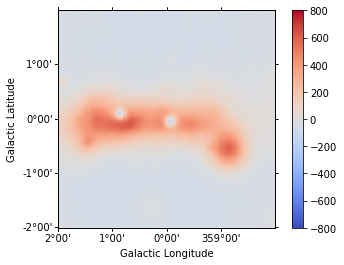

In [18]:
residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-800, vmax=800, add_cbar=True);

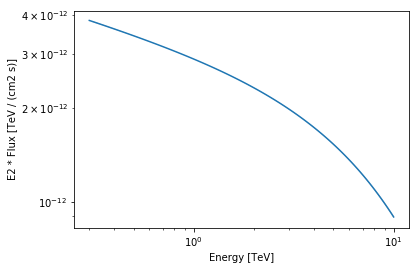

In [19]:
# GC source spectrum:
spec_1 = result.model.spectral_model
energy_range = [0.3, 10] * u.TeV
spec_1.plot(energy_range=energy_range, energy_power=2)
ax = spec_1.plot_error(energy_range=energy_range, energy_power=2)

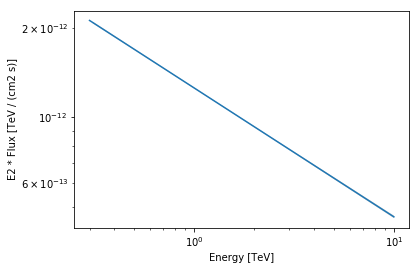

In [20]:
# G0.9+0.1 spectrum
spec_2 = result_2.model.spectral_model
energy_range = [0.3, 10] * u.TeV
spec_2.plot(energy_range=energy_range, energy_power=2)
ax = spec_2.plot_error(energy_range=energy_range, energy_power=2)

Compare to DC1 model:

In [22]:
dc1_gc_model = ExponentialCutoffPowerLaw(
    index = 2.14 * u.Unit(''),
    amplitude = 2.55e-12 * u.Unit('cm-2 s-1 TeV-1'),
    reference= 1. * u.TeV,
    lambda_= 0.0934 / u.TeV
)
dc1_G09_model = PowerLaw(
    index = 2.4 * u.Unit(''),
    amplitude = 0.8383e-12 * u.Unit('cm-2 s-1 TeV-1'),
    reference= 1. *u.TeV,
)

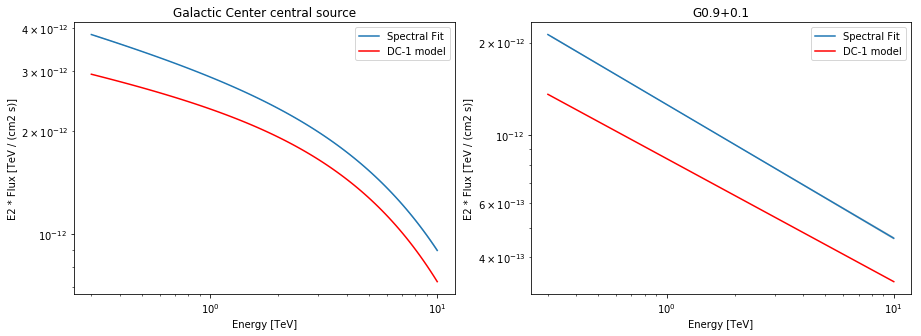

In [39]:
energy_range = [0.3, 10] * u.TeV

plt.figure(figsize=(15, 5))

ax_1 = plt.subplot(121)
ax_2 = plt.subplot(122)

ax_1.set_title("Galactic Center central source")
ax_2.set_title("G0.9+0.1")

spec_1.plot(energy_range=energy_range, energy_power=2,ax=ax_1)
ax = spec_1.plot_error(energy_range=energy_range, energy_power=2,ax=ax_1)
ax = dc1_gc_model.plot(energy_range, energy_power=2, color='red',ax=ax_1)
ax.legend(['Spectral Fit', 'DC-1 model'])

spec_2.plot(energy_range=energy_range, energy_power=2,ax=ax_2)
ax = spec_2.plot_error(energy_range=energy_range, energy_power=2,ax=ax_2)
ax = dc1_G09_model.plot(energy_range, energy_power=2, color='red',ax=ax_2)
ax.legend(['Spectral Fit', 'DC-1 model'])

## Fit of the HESS J1745-303 source

In [40]:
fit_3 = MapFit(
    model=model_J1745_303,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
#    mask=mask_J1745_303,
    psf=psf_kernel,
    edisp=edisp,
)
fit_3.evaluator.model.parameters["lon_0"].frozen = True
fit_3.evaluator.model.parameters["lat_0"].frozen = True
fit_3.evaluator.model.parameters["sigma"].min = 0
fit_3.evaluator.model.parameters["sigma"].max = 0.4

In [41]:
%%time
result_3 = fit_3.run(optimize_opts={"print_level": 1})

FCN = -170392697.76577285 
 TOTAL NCALL = 248 
 NCALLS = 248 
 
 
 EDM = 0.0004598806178317584 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,par_000_lon_0,3.58872,1,,,,,Yes
1,par_001_lat_0,-0.578,1,,,,,Yes
2,par_002_sigma,0.4,4.64819e-06,,,0,0.4,No
3,par_003_index,2.49953,0.00169649,,,,,No
4,par_004_amplitude,8.46094,0.0195326,,,,,No
5,par_005_reference,1,1,,,0,,Yes


CPU times: user 1min 31s, sys: 319 ms, total: 1min 31s
Wall time: 1min 31s


In [42]:
print(result_3.model)

SkyModel

spatial_model = SkyGaussian

Parameters: 

	 name   value      error   unit    min       max   
	----- ---------- --------- ---- --------- ---------
	lon_0  3.589e+02 0.000e+00  deg       nan       nan
	lat_0 -5.780e-01 0.000e+00  deg       nan       nan
	sigma  4.000e-01 4.629e-08  deg 0.000e+00 4.000e-01

Covariance: 

	 name   lon_0     lat_0     sigma  
	----- --------- --------- ---------
	lon_0 0.000e+00 0.000e+00 0.000e+00
	lat_0 0.000e+00 0.000e+00 0.000e+00
	sigma 0.000e+00 0.000e+00 2.142e-15

spectral_model = PowerLaw

Parameters: 

	   name     value     error         unit         min    max
	--------- --------- --------- --------------- --------- ---
	    index 2.500e+00 1.696e-03                       nan nan
	amplitude 8.461e-12 1.953e-14 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00 0.000e+00             TeV 0.000e+00 nan

Covariance: 

	   name     index    amplitude  reference
	--------- ---------- ---------- ---------
	    index  2.878e-06 -1.164e-17 0

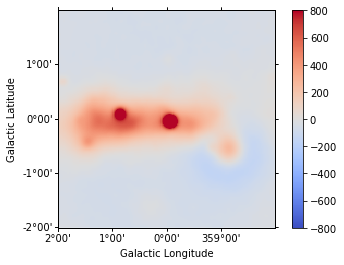

In [56]:
npred_3 = fit_3.evaluator.compute_npred()
residual3 = Map.from_geom(cmaps["counts"].geom)
residual3.data = cmaps["counts"].data - npred_3.data 
residual3.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-800, vmax=800, add_cbar=True);

The fit is poor due to the lack of IEM model. The width of the gaussian goes to larger values (true value is actually 0.2 deg) because it tries to fit the IEM component. Lets add the IEM.

## Adding IEM model
First without HESS J1745-303:

In [44]:
model_combined = fit.evaluator.model + fit_2.evaluator.model + model_iem

#model_combined = fit.evaluator.model + fit_2.evaluator.model + fit_3.evaluator.model + model_iem

fit_combined = MapFit(
    model=model_combined,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    psf=psf_kernel,
    edisp=edisp,
)

In [45]:
print(model_combined)

CompoundSkyModel
    Component 1 : CompoundSkyModel
    Component 1 : SkyModel

spatial_model = SkyPointSource

Parameters: 

	 name   value      error   unit min max
	----- ---------- --------- ---- --- ---
	lon_0 -5.519e-02 1.121e-04  deg nan nan
	lat_0 -4.634e-02 1.128e-04  deg nan nan

Covariance: 

	 name   lon_0     lat_0  
	----- --------- ---------
	lon_0 1.257e-08 5.854e-11
	lat_0 5.854e-11 1.273e-08

spectral_model = ExponentialCutoffPowerLaw

Parameters: 

	   name     value     error         unit      min max
	--------- --------- --------- --------------- --- ---
	    index 2.190e+00 4.952e-03                 nan nan
	amplitude 3.124e-12 1.283e-14 1 / (cm2 s TeV) nan nan
	reference 1.000e+00 0.000e+00             TeV nan nan
	  lambda_ 8.110e-02 1.792e-03         1 / TeV nan nan

Covariance: 

	   name     index    amplitude  reference  lambda_  
	--------- ---------- ---------- --------- ----------
	    index  2.452e-05 -3.478e-17 0.000e+00 -7.161e-06
	amplitude -3.478e-17

In [46]:
# Fixing the positions
fit_combined.evaluator.model.model1.model1.parameters["lon_0"].frozen = True
fit_combined.evaluator.model.model1.model1.parameters["lat_0"].frozen = True

fit_combined.evaluator.model.model1.model2.parameters["lon_0"].frozen = True
fit_combined.evaluator.model.model1.model2.parameters["lat_0"].frozen = True

In [47]:
%%time
result_combined = fit_combined.run(optimize_opts={"print_level": 1})

FCN = -172508599.84878045 
 TOTAL NCALL = 233 
 NCALLS = 233 
 
 
 EDM = 0.0727788768535195 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,par_000_lon_0,-0.551909,1,,,,,Yes
1,par_001_lat_0,-0.463434,1,,,,,Yes
2,par_002_index,2.12942,0.0038169,,,,,No
3,par_003_amplitude,0.265459,0.00122647,,,,,No
4,par_004_reference,1,1,,,,,Yes
5,par_005_lambda_,0.975693,0.0182097,,,,,No
6,par_006_lon_0,0.863329,1,,,,,Yes
7,par_007_lat_0,0.902297,1,,,,,Yes
8,par_008_index,2.38703,0.00389781,,,,,No
9,par_009_amplitude,0.0875229,0.000448212,,,,,No


CPU times: user 5min, sys: 18.3 s, total: 5min 18s
Wall time: 5min 19s


In [48]:
print(result_combined.model)

CompoundSkyModel
    Component 1 : CompoundSkyModel
    Component 1 : SkyModel

spatial_model = SkyPointSource

Parameters: 

	 name   value      error   unit min max
	----- ---------- --------- ---- --- ---
	lon_0 -5.519e-02 1.121e-04  deg nan nan
	lat_0 -4.634e-02 1.128e-04  deg nan nan

Covariance: 

	 name   lon_0     lat_0  
	----- --------- ---------
	lon_0 1.257e-08 5.854e-11
	lat_0 5.854e-11 1.273e-08

spectral_model = ExponentialCutoffPowerLaw

Parameters: 

	   name     value     error         unit      min max
	--------- --------- --------- --------------- --- ---
	    index 2.129e+00 4.952e-03                 nan nan
	amplitude 2.655e-12 1.283e-14 1 / (cm2 s TeV) nan nan
	reference 1.000e+00 0.000e+00             TeV nan nan
	  lambda_ 9.757e-02 1.792e-03         1 / TeV nan nan

Covariance: 

	   name     index    amplitude  reference  lambda_  
	--------- ---------- ---------- --------- ----------
	    index  2.452e-05 -3.478e-17 0.000e+00 -7.161e-06
	amplitude -3.478e-17

In [49]:
fit_combined.evaluator.model.model2.parameters[:]

[Parameter(name='norm', value=0.8401770723998022, factor=0.8401770723998022, scale=1, unit='', min=nan, max=nan, frozen=False)]

The IEM normalization is found at 0.84, instead of 1. Let's check the residuals.

In [50]:
npred_combined = fit_combined.evaluator.compute_npred()

residual2 = Map.from_geom(cmaps["counts"].geom)
residual2.data = cmaps["counts"].data - npred_combined.data

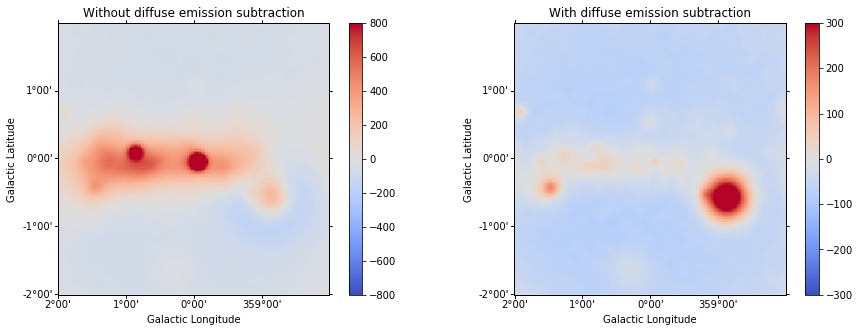

In [52]:
plt.figure(figsize=(15, 5))
ax_1 = plt.subplot(121, projection=residual.geom.wcs)
ax_2 = plt.subplot(122, projection=residual.geom.wcs)

ax_1.set_title("Without diffuse emission subtraction")
ax_2.set_title("With diffuse emission subtraction")

residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin = -800, vmax=800, add_cbar=True, ax=ax_1
);
residual2.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin = -300, vmax=300, add_cbar=True, ax=ax_2
);

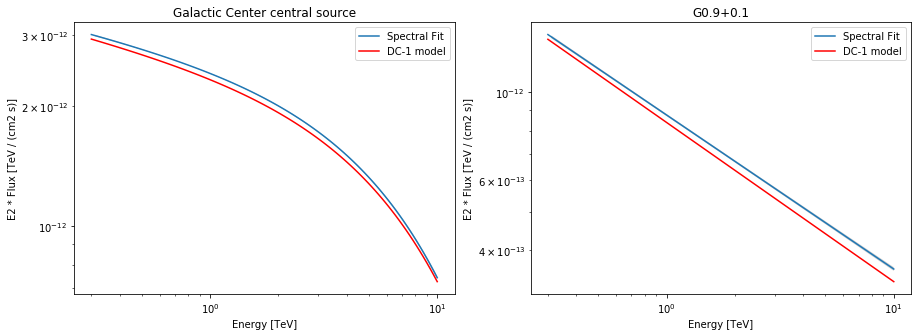

In [55]:
# GC source spectrum:
spec_1 = result_combined.model.model1.model1.spectral_model

# G0.9+0.1 spectrum
spec_2 = result_combined.model.model1.model2.spectral_model

plt.figure(figsize=(15, 5))

ax_1 = plt.subplot(121)
ax_2 = plt.subplot(122)

ax_1.set_title("Galactic Center central source")
ax_2.set_title("G0.9+0.1")

spec_1.plot(energy_range=energy_range, energy_power=2,ax=ax_1)
ax = spec_1.plot_error(energy_range=energy_range, energy_power=2,ax=ax_1)
ax = dc1_gc_model.plot(energy_range, energy_power=2, color='red',ax=ax_1)
ax.legend(['Spectral Fit', 'DC-1 model'])

spec_2.plot(energy_range=energy_range, energy_power=2,ax=ax_2)
ax = spec_2.plot_error(energy_range=energy_range, energy_power=2,ax=ax_2)
ax = dc1_G09_model.plot(energy_range, energy_power=2, color='red',ax=ax_2)
ax.legend(['Spectral Fit', 'DC-1 model'])

The fit has improved significantly. However, there is still some IEM not being fit. Let's try to add HESS J1745-303.
## Adding IEM and HESS J1745-303 (ongoing)

In [65]:
model_combined_2 = result_combined.model.model1.model1 + result_combined.model.model1.model2 + fit_3.evaluator.model + result_combined.model.model2

fit_combined_2 = MapFit(
    model=model_combined_2,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    psf=psf_kernel,
    edisp=edisp,
)

In [78]:
# Fixing the positions
fit_combined_2.evaluator.model.model1.model1.model1.parameters["lon_0"].frozen = True
fit_combined_2.evaluator.model.model1.model1.model1.parameters["lat_0"].frozen = True

fit_combined_2.evaluator.model.model1.model1.model2.parameters["lon_0"].frozen = True
fit_combined_2.evaluator.model.model1.model1.model2.parameters["lat_0"].frozen = True

fit_combined_2.evaluator.model.model1.model2.parameters["lon_0"].frozen = True
fit_combined_2.evaluator.model.model1.model2.parameters["lat_0"].frozen = True
fit_combined_2.evaluator.model.model1.model2.parameters["sigma"].max = 0.4
fit_combined_2.evaluator.model.model1.model2.parameters["amplitude"].min = 0 

fit_combined_2.evaluator.model.model2.parameters["norm"].min = 0
#fit_combined_2.evaluator.model.model2.parameters["norm"].max = 1.2

In [73]:
#print(fit_combined_2.evaluator.model.model1.model2)

In [79]:
%%time
result_combined_2 = fit_combined_2.run(optimize_opts={"print_level": 1})

FCN = -172605545.76919726 
 TOTAL NCALL = 269 
 NCALLS = 269 
 
 
 EDM = 0.022714003252639604 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,par_000_lon_0,-0.551909,1,,,,,Yes
1,par_001_lat_0,-0.463434,1,,,,,Yes
2,par_002_index,2.13783,0.00377087,,,,,No
3,par_003_amplitude,0.266812,0.0012214,,,,,No
4,par_004_reference,1,1,,,,,Yes
5,par_005_lambda_,0.953468,0.0179427,,,,,No
6,par_006_lon_0,0.863329,1,,,,,Yes
7,par_007_lat_0,0.902297,1,,,,,Yes
8,par_008_index,2.39394,0.00385296,,,,,No
9,par_009_amplitude,0.892565,0.00450664,,,,,No


CPU times: user 6min 5s, sys: 18.5 s, total: 6min 24s
Wall time: 6min 25s


In [80]:
npred_combined_2 = fit_combined_2.evaluator.compute_npred()

residual_comb = Map.from_geom(cmaps["counts"].geom)
residual_comb.data = cmaps["counts"].data - npred_combined_2.data

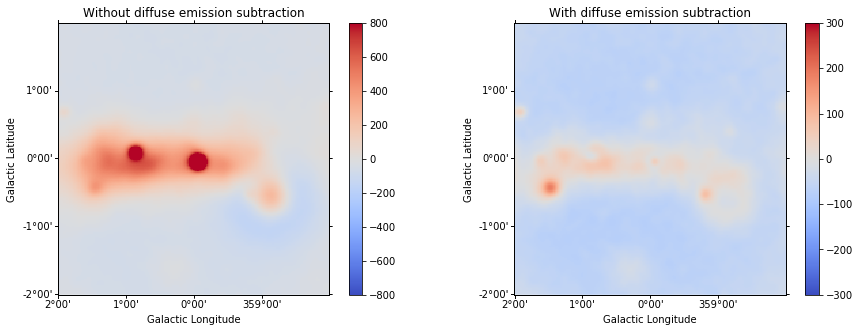

In [81]:
plt.figure(figsize=(15, 5))
ax_1 = plt.subplot(121, projection=residual.geom.wcs)
ax_2 = plt.subplot(122, projection=residual.geom.wcs)

ax_1.set_title("Without diffuse emission subtraction")
ax_2.set_title("With diffuse emission subtraction")

residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin = -800, vmax=800, add_cbar=True, ax=ax_1
);
residual_comb.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin = -300, vmax=300, add_cbar=True, ax=ax_2
);